### Libraries

In [3]:
import sys
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import shapely
import geopandas as gpd
import topojson as tp
import rasterio
import rasterio.plot
import rasterio.warp
import rasterio.mask

### Data Files

In [4]:
seine = gpd.read_file('data/seine.gpkg')
us_states = gpd.read_file('data/us_states.gpkg')
nz = gpd.read_file('data/nz.gpkg')
src = rasterio.open('data/dem.tif')
src_elev = rasterio.open('output/elev.tif')

## Geometry Operations
* Unary - Operations on one object
* Binary - Changing the characteristics of one object based on the characteristics of another
* Type - Changing the type of object, e.g. a polygon into a line

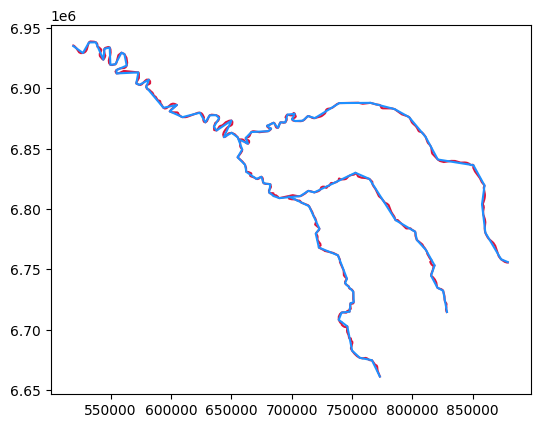

In [7]:
# simplify reduces the resolution / memory of a geometry
# within a tolerance of 2000m
seine_simp = seine.simplify(2000)

fig, ax = plt.subplots()
seine.plot(ax = ax, color = 'crimson');
seine_simp.plot(ax = ax, color = 'dodgerblue');

In [16]:
us_states9311 = us_states[us_states9311.NAME.isin(['Michigan', 'Wisconsin', 'Ohio'])].to_crs(9311)

# geopandas simplify method does not preserve boundaries
us_states_simp1 = us_states9311[us_states9311.NAME.isin(['Michigan', 'Wisconsin', 'Ohio'])].simplify(100000)

# simplify keeping boundaries together
us_states_simp2 = tp.Topology(us_states9311[us_states9311.NAME.isin(['Michigan', 'Wisconsin', 'Ohio'])], prequantize=False).toposimplify(100000).to_gdf()

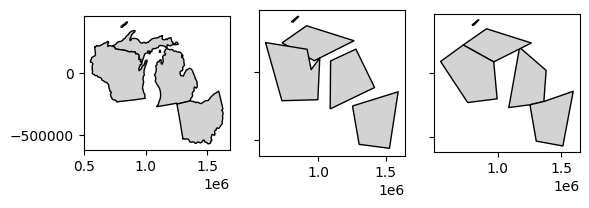

In [18]:
fig, ax = plt.subplots(1, 3, sharey = True)
us_states9311.plot(color='lightgrey', edgecolor='black', ax = ax[0]);
us_states_simp1.plot(color='lightgrey', edgecolor='black', ax = ax[1]);
us_states_simp2.plot(color='lightgrey', edgecolor='black', ax = ax[2]);

### Centroids and Buffers

Both methods return a GeoSeries object, even if the input is a GeoDataFrame

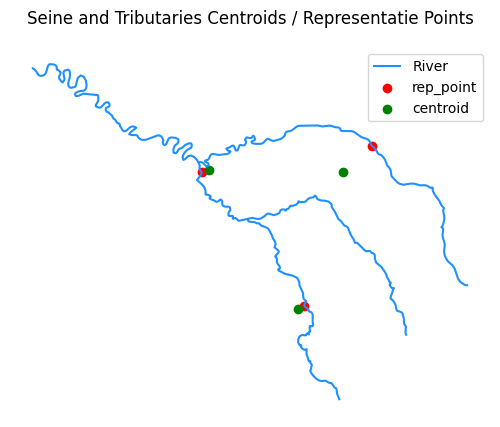

In [28]:
seine_centroid = seine.centroid
seine_pos = seine.representative_point()
base = seine.plot(color='dodgerblue')
seine_pos.plot(ax=base, color='red', edgecolor='red')
seine_centroid.plot(ax=base, color='green', edgecolor='green')
plt.legend(['River','rep_point', 'centroid'])
plt.title('Seine and Tributaries Centroids / Representatie Points')
base.set_axis_off()
plt.show()

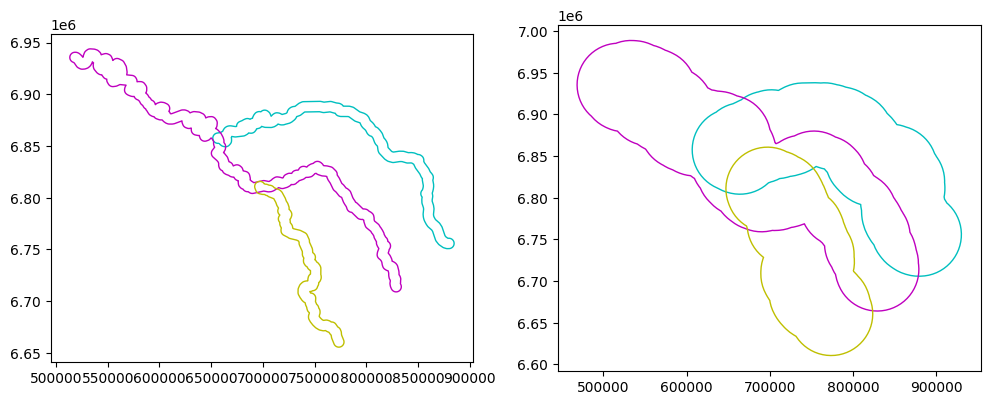

In [33]:
seine_buff_5km = seine.buffer(5000)
seine_buff_50km = seine.buffer(50000)

fig, ax = plt.subplots(1,2, figsize = (12, 6))
seine_buff_5km.plot(color='none', edgecolor=['c', 'm', 'y'], ax = ax[0]);
seine_buff_50km.plot(color='none', edgecolor=['c', 'm', 'y'], ax = ax[1]);

### Affine Transformations


* .translate(xoff=0.0, yoff=0.0) shifts coordinates
* .scale(xfact=1.0, yfact=1.0, origin='center') scales vectors by a factor
* .rotate(angle, origin='center', use_radians=False) rotates vecotrs around a central point


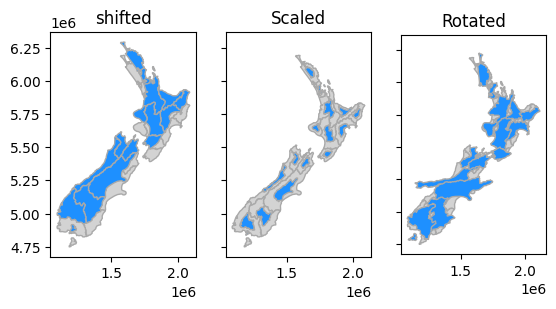

In [38]:
nz_rotate = nz.rotate(-30, origin='centroid')
nz_scale = nz.scale(0.5, 0.5, origin='centroid')
nz_shift = nz.translate(0, 100000)

fig, ax = plt.subplots(1, 3, sharey = True)

# Shift
nz.plot(color='lightgrey', edgecolor='darkgrey', ax = ax[0])
nz_shift.plot(ax=ax[0], color='dodgerblue', edgecolor='darkgrey')
# Scale
nz.plot(color='lightgrey', edgecolor='darkgrey', ax = ax[1])
nz_scale.plot(ax=ax[1], color='dodgerblue', edgecolor='darkgrey')
# Rotate
nz.plot(color='lightgrey', edgecolor='darkgrey', ax = ax[2])
nz_rotate.plot(ax=ax[2], color='dodgerblue', edgecolor='darkgrey')
ax[0].set_title('shifted')
ax[1].set_title('Scaled')
ax[2].set_title('Rotated')
plt.show()